# Predicting brain activity from word embeddings during natural language comprehension
This tutorial introduces a typical **enc**oding framework for mapping **ling**uistic embeddings onto human brain activity during natural language comprehension. The tutorial includes worked examples for both fMRI and ECoG datasets collected while subjects listened to naturalistic spoken narratives. Two types of word embeddings are obtained based on the stimulus transcripts: static word embeddings from word2vec and contextual word embeddings from GPT-2. Encoding models are estimated using banded ridge regression—this allows us to predict brain activity from word embeddings for left-out segments of data.

*Acknowledgments:* This tutorial draws heavily on work by Zaid Zada (e.g. code from [Zada et al., 2023](https://doi.org/10.1101/2023.06.27.546708)) as well as Gallant Lab's [voxelwise modeling tutorials](https://gallantlab.org/voxelwise_tutorials/index.html).

In [50]:
from os.path import exists
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm.notebook import tqdm

# Explicitly set locale character type to English
!export LC_CTYPE="en_US.UTF-8"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Extracting word embeddings
In the following sections, we extract two types of vectors—called "word embeddings"—capturing the meaning of words. In both cases, words are encoded as vectors of continuous numeric values in a high-dimensional embedding space where each dimension corresponds to an internal feature of the model. Words that are similar to each other are located nearing to each other in this embedding space.

### Static word embeddings
In the first case, we'll retrieve static, noncontextual word embeddings from a pre-trained model called word2vec ([Mikolov et al., 2013](https://papers.nips.cc/paper_files/paper/2013/hash/9aa42b31882ec039965f3c4923ce901b-Abstract.html)). 

In [2]:
import gensim.downloader

# Download 300-dimensional word2vec embeddings
model_name = 'word2vec-google-news-300'
n_features = 300

model = gensim.downloader.load(model_name)

In [3]:
# Load in transcript CSV file
transcript_f = 'black_transcript.csv'
transcript_df = pd.read_csv(transcript_f)

# Convert words to lowercase
transcript_df['word'] = transcript_df.word.str.lower()

# Function to extract embeddings if available
def get_vector(word):
    if word in model.key_to_index:
        return model.get_vector(word, norm=True).astype(np.float32)
    return np.nan

# Extract embedding for each word
transcript_df['embedding'] = transcript_df.word.apply(get_vector)  
transcript_df = transcript_df.astype({'onset': 'float32', 'offset': 'float32'}, copy=False)

# Print out words not found in vocabulary
print(f'{(transcript_df.embedding.isna()).sum()} words not found:')
print(transcript_df.word[transcript_df.embedding.isna()].value_counts())

# Save transcript with embeddings using pickle
with open('black_word2vec.pkl', 'wb') as f:
    pickle.dump(transcript_df, f)

208 words not found:
and        70
to         43
i'm        30
of         30
a          27
i'd         5
sheldon     1
mhm         1
50          1
Name: word, dtype: int64


In [4]:
# Reload transcript with embeddings if already generated
transcript_f = 'black_word2vec.pkl'
if exists(transcript_f):
    with open(transcript_f, 'rb') as f:
        transcript_df = pickle.load(f)

### Contextual word embeddings
In the second case, we'll extract contextual word embeddings from an autoregressive (or "causal") large language model called GPT-2 ([Radford et al., 2019](https://d4mucfpksywv.cloudfront.net/better-language-models/language-models.pdf)).

In [5]:
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM

# Initialize tokenizer and model
model_name = 'gpt2'

tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Print out model architecture
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [6]:
# Get device for running model (e.g. MacOS 'mps')
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)

# We need to force CPU due to a Pytorch bug with MPS
device = 'cpu'

print(f"Using {device} device")

Using cpu device


In [7]:
# Reload in transcript CSV file
transcript_f = 'black_transcript.csv'
transcript_df = pd.read_csv(transcript_f)

# Insert explicit index column for reference
transcript_df.insert(0, 'word_index', transcript_df.index.values)

# Tokenize words into lists of tokens
transcript_df['token'] = transcript_df.word.apply(tokenizer.tokenize)

# "Explode" lists of token subwords into long format
transcript_df = transcript_df.explode('token', ignore_index=True)

# Convert tokens to token IDs for input to model
transcript_df['token_id'] = transcript_df.token.apply(tokenizer.convert_tokens_to_ids)

In [8]:
# Convert all token IDs into list
token_ids = transcript_df.token_id.tolist()

# Extract context window width for model
max_len = tokenizer.model_max_length

# Compile into lists of tokens within each context window
examples = []
token_ids = torch.tensor(transcript_df.token_id.tolist(), dtype=torch.long)
examples.append(token_ids[0:max_len])
for i in range(max_len+1, len(token_ids)+1):
    examples.append(token_ids[i-max_len:i])

In [9]:
from accelerate import Accelerator

# Initialize accelerator and free memory
accelerator = Accelerator()
accelerator.free_memory()

# Send model to device
model = model.to(device)

Finally, we'll use pytorch DataLoader to supply token IDs to the model and extract the embeddings.

In [10]:
batch_size = 4
layer = 8

top_guesses = []
ranks = []
true_probs = []
entropies = []
embeddings = []
with torch.no_grad():
    data_loader = torch.utils.data.DataLoader(examples, batch_size=batch_size,
                                              shuffle=False)
    for i, batch in enumerate(tqdm(data_loader)):
        output = model(batch.to(device), output_hidden_states=True)
        logits = output.logits  # torch.Size([2, 1024, 50257])
        states = output.hidden_states[layer]

        # first case
        if i == 0:
            true_ids = batch[0, :]
            brange = list(range(len(true_ids)-1))
            logits_order = logits[0].argsort(descending=True, dim=-1)
            batch_top_guesses = logits_order[:-1, 0]
            batch_ranks = torch.eq(logits_order[:-1], true_ids.reshape(-1,1)[1:].to(device)).nonzero()[:, 1]
            batch_probs = logits[0, :-1].softmax(-1)
            batch_true_probs = batch_probs[brange, true_ids[1:]]
            batch_entropy = torch.distributions.Categorical(probs=batch_probs).entropy()
            batch_embeddings = states[0]

            top_guesses.append(batch_top_guesses.numpy(force=True))
            ranks.append(batch_ranks.numpy(force=True))
            true_probs.append(batch_true_probs.numpy(force=True))
            entropies.append(batch_entropy.numpy(force=True))
            embeddings.append(batch_embeddings.numpy(force=True))
            
            # reset if there are more in this batch
            if batch.size(0) == 1:
                continue
            logits = logits[1:]
            states = states[1:]
            batch = batch[1:]

        # general case
        true_ids = batch[:, -1]
        brange = list(range(len(true_ids)))
        logits_order = logits[:, -2, :].argsort(descending=True)  # batch x vocab_size
        batch_top_guesses = logits_order[:, 0]
        batch_ranks = torch.eq(logits_order, true_ids.reshape(-1,1).to(device)).nonzero()[:, 1]
        batch_probs = torch.softmax(logits[:, -2, :], dim=-1)
        batch_true_probs = batch_probs[brange, true_ids]
        batch_entropy = torch.distributions.Categorical(probs=batch_probs).entropy()
        batch_embeddings = states[:, -1, :]

        top_guesses.append(batch_top_guesses.numpy(force=True))
        ranks.append(batch_ranks.numpy(force=True))
        true_probs.append(batch_true_probs.numpy(force=True))
        entropies.append(batch_entropy.numpy(force=True))
        embeddings.append(batch_embeddings.numpy(force=True))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/153 [00:00<?, ?it/s]

Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized



In [16]:
# Compile outputs into transcript (logit derivatives must be shifted by 1)
transcript_df.loc[1:, 'rank'] = np.concatenate(ranks)
transcript_df.loc[1:, 'true_prob'] = np.concatenate(true_probs)
transcript_df.loc[1:, 'top_pred'] = np.concatenate(top_guesses)
transcript_df.loc[0, 'top_pred'] = tokenizer.bos_token_id
transcript_df.loc[1:, 'entropy'] = np.concatenate(entropies)
transcript_df['embedding'] = [e for e in np.vstack(embeddings)]

# Reduce size of transcript
transcript_df = transcript_df.astype({'word_index': 'int32', 'onset': 'float32',
                                      'offset': 'float32', 'token_id': 'int32',
                                      'rank': 'float32', 'true_prob': 'float32',
                                      'top_pred': 'int32', 'entropy': 'float32'}, copy=False)

# Convert model's top predictions from token IDs to tokens
transcript_df['top_pred'] = transcript_df.top_pred.apply(tokenizer.convert_ids_to_tokens)

# Print out top-1 and top-10 word prediction accuracy
print(f"Top-1 accuracy: {(transcript_df['rank'] == 0).mean():.3f}")
print(f"Top-10 accuracy: {(transcript_df['rank'] < 10).mean():.3f}")

# Save transcript with embeddings using pickle
with open('black_gpt2.pkl', 'wb') as f:
    pickle.dump(transcript_df, f)

Top-1 accuracy: 0.317
Top-10 accuracy: 0.656


In [19]:
# Reload transcript with embeddings if already generated
transcript_f = 'black_gpt2.pkl'
if exists(transcript_f):
    with open(transcript_f, 'rb') as f:
        transcript_df = pickle.load(f)

## Naturalistic story-listening fMRI data
As an example, we'll use fMRI data collected for a single subject listening to a spoken story called "[I Knew You Were Black](https://themoth.org/stories/i-knew-you-were-black)" by Carol Daniel. These data are available as part of the publicly available [Narratives](https://github.com/snastase/narratives) collection ([Nastase et al., 2019](https://openneuro.org/datasets/ds002345)). This dataset has been preprocessed using fMRIPrep with confound regression in AFNI. The functional data have been spatially normalized to a template in MNI space. To reduce computational demands, we compute parcel-wise ISCs using a cortical parcellation containing 400 parcels from [Schaefer and colleages (2018)](https://doi.org/10.1093/cercor/bhx179).

In [22]:
from nilearn.datasets import fetch_atlas_schaefer_2018
from nilearn.maskers import NiftiLabelsMasker

func_fn = ('sub-284_task-black_space-MNI152NLin2009cAsym_res-native_desc-clean_bold.nii.gz')

# Fetch Schaefer atlas with 400 parcels and 17 Yeo networks
atlas = fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=17, resolution_mm=2)

# Initialize labels masker with atlas parcels
masker = NiftiLabelsMasker(atlas.maps, labels=atlas.labels)

# Fit masker to extract mean time series for parcels
func_parcels = masker.fit_transform(func_fn)

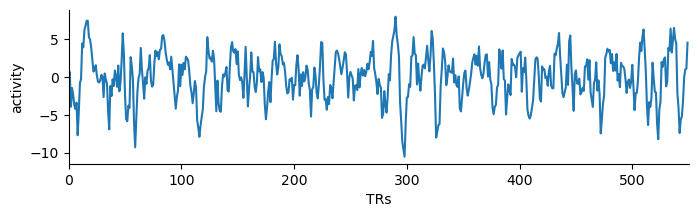

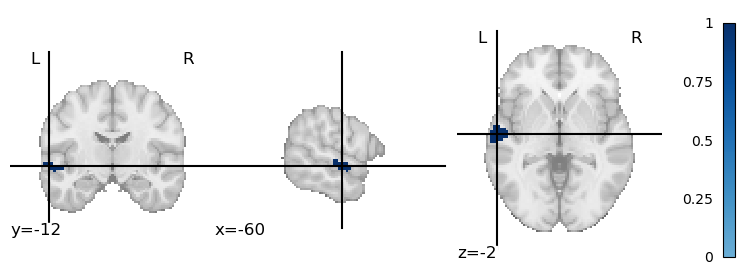

In [23]:
# Plot the time series for an example parcel
from nilearn.plotting import plot_stat_map

example_parcel = 195
func_parcel = func_parcels[:, example_parcel]

fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(func_parcel)
ax.set(xlabel='TRs', ylabel='activity', xlim=(0, len(func_parcel)))
sns.despine()

# Plot parcel on MNI atlas
parcels_label = np.zeros(func_parcels.shape[1])
parcels_label[example_parcel] = 1

# Invert masker transform to project onto brain
parcel_img = masker.inverse_transform(parcels_label)
plot_stat_map(parcel_img, cmap='Blues');

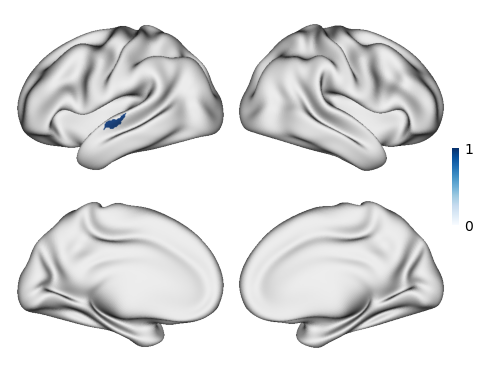

In [24]:
from surfplot import Plot
from neuromaps.datasets import fetch_fslr
from neuromaps.transforms import mni152_to_fslr

# Fetch fsLR surfaces from neuromaps
surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
sulc_lh, sulc_rh = surfaces['sulc']

# Convert volumetric MNI data to fsLR surface
gii_lh, gii_rh = mni152_to_fslr(parcel_img, method='nearest')

# Plot example ROI on surface
p = Plot(surf_lh=lh, surf_rh=rh, brightness=.7)
p.add_layer({'left': gii_lh, 'right': gii_rh}, cmap='Blues', color_range=(0, 1))
cbar_kws = dict(location='right', draw_border=False, aspect=10,
                shrink=.2, decimals=0, pad=0, n_ticks=2)
fig = p.build(cbar_kws=cbar_kws)

### Construct predictors

In [27]:
# Dimensionality of model for filling in blank TRs
n_features = 768

# Stimulus is roughly 800 seconds long
tr = 1.5
stim_dur = 800
stim_trs = np.ceil(800 / tr)

# Add column to transcript with TR indices
transcript_df['TR'] = transcript_df.onset.divide(tr).apply(np.floor).apply(int)

# Compile the words within each TR
words_per_tr = transcript_df.groupby('TR')['word'].apply(list)

# Average the embeddings within each TR
embeddings_per_tr = transcript_df.groupby('TR')['embedding'].mean()

# Loop through TRs
words_trs = []
embeddings_trs = []
for t in np.arange(stim_trs):
    if t in words_per_tr:
        words_trs.append(words_per_tr[t])

        # Fill in empty TRs with zero vectors
        if embeddings_per_tr[t] is not np.nan:
            embeddings_trs.append(embeddings_per_tr[t])
        else:
            embeddings_trs.append(np.zeros(n_features))
    else:
        words_trs.append([])
        embeddings_trs.append(np.zeros(n_features))

embeddings = np.vstack(embeddings_trs)

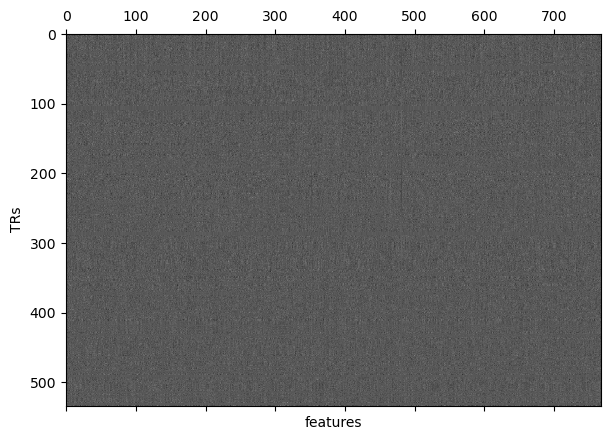

In [28]:
# Visualize predictor matrix of word embeddings:
from scipy.stats import zscore
plt.matshow(zscore(embeddings, axis=0), cmap='binary_r')
plt.xlabel('features')
plt.ylabel('TRs');

In [29]:
# Trim fMRI data to match embeddings:
start_trs = 8
end_trs = 8

assert start_trs + embeddings.shape[0] + end_trs == func_parcels.shape[0]

func_parcels = func_parcels[start_trs:-end_trs]

## Encoding models
Next, we use ridge regression to predict the activity at each parcel from the word embeddings. Note that the model dimensionality of the model is much greater than the number of samples. This means we'll need to impose strong regularization on the model. Use a split-half outer cross-validation scheme where we train the model on half of the story and test the model on the other half. To search for the best-performing regularization parameter, perform 5-fold inner cross-validation within each training set using `KernelRidgeCV`; this will select the best parameter setting from the inner cross-validation fold within the training half to predict the test half.

In [65]:
from sklearn.preprocessing import StandardScaler
from voxelwise_tutorials.delayer import Delayer
from sklearn.model_selection import KFold
from himalaya.kernel_ridge import KernelRidgeCV
from sklearn.pipeline import make_pipeline

# Mean-center each feature (columns of predictor matrix)
scaler = StandardScaler(with_mean=True, with_std=True)

# Create delays at 3, 4.5, 6, 7.5 seconds (1.5 s TR)
delayer = Delayer(delays=[2, 3, 4, 5])

# Split-half outer and inner cross-validation
outer_cv = KFold(n_splits=2)
inner_cv = KFold(n_splits=5)

# Ridge regression with alpha grid and nested CV
alphas = np.logspace(1, 10, 10)
ridge = KernelRidgeCV(alphas=alphas, cv=inner_cv)

# Chain transfroms and estimator into pipeline
pipeline = make_pipeline(scaler, delayer, ridge)

In [66]:
# Loop through outer folds and estimate model
func_predicted = []
for train, test in outer_cv.split(func_parcels):
    
    # Fit pipeline with transforms and ridge estimator
    pipeline.fit(embeddings[train],
                 func_parcels[train])
    
    # Compute predicted response
    predicted = pipeline.predict(embeddings[test])
    func_predicted.append(predicted)
    
# Restack first and second half predictions
func_predicted = np.vstack(func_predicted)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


To evaluate the predictions of our model, we use the model weights estimated from the training data to predict the brain activity from word embeddings for the test data. We then assess the similarity between the predicted brain activity and the actual brain activity for the test data. Keeping with conventions in the literature, we use Pearson correlation to assess the match between predicted and actual brain activity. For each parcel, compute the Pearson correlation between the actual and predicted test time series.

Mean encoding performance: r = 0.094
Maximum encoding performance: r = 0.418


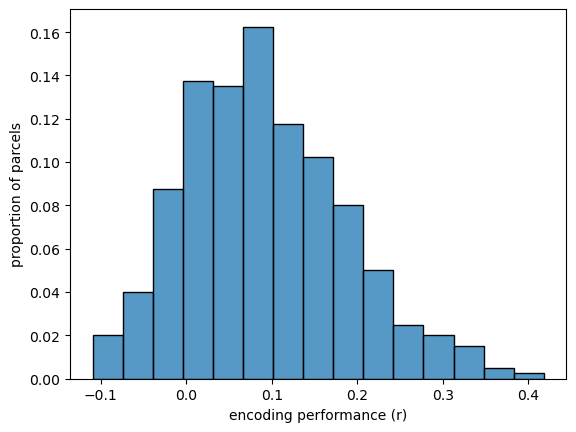

In [67]:
from himalaya.scoring import correlation_score

# Evaluate predictions: correlation between predicted and actual time series
r_parcels = correlation_score(func_predicted, func_parcels)

print(f"Mean encoding performance: r = {np.mean(r_parcels):.3f}")
print(f"Maximum encoding performance: r = {np.amax(r_parcels):.3f}")

# Plot a histogram of prediction performance values
fig, ax = plt.subplots()
sns.histplot(r_parcels, stat='proportion', ax=ax)
ax.set(xlabel='encoding performance (r)', ylabel='proportion of parcels');

In [58]:
# Introspect fitted pipeline model for alphas and weights
ridge_fitted = pipeline['kernelridgecv']
best_alphas = ridge_fitted.best_alphas_
cv_scores = ridge_fitted.cv_scores_
weights = ridge_fitted.get_primal_coef(ridge_fitted.X_fit_)

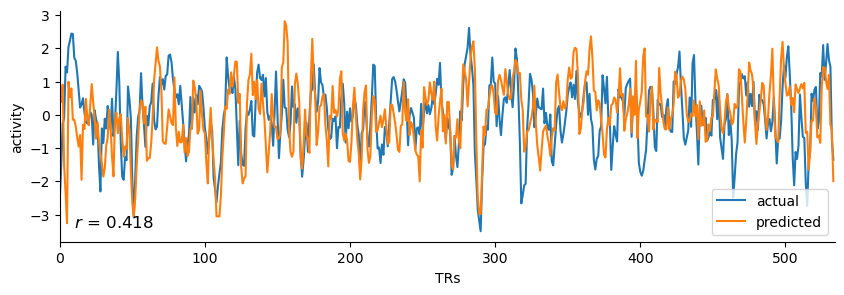

In [59]:
# Plot predicted and actual response for example parcel:
example_parcel = 195
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(zscore(func_parcels[:, example_parcel]), label='actual')
ax.plot(zscore(func_predicted[:, example_parcel]), label='predicted')
ax.annotate(f'$\it{{r}}$ = {r_parcels[example_parcel]:.3f}',
            xy=(10, 10), xycoords='axes points', fontsize=12)
ax.set(xlabel='TRs', ylabel='activity', xlim=(0, func_predicted.shape[0]))
ax.legend()
sns.despine()

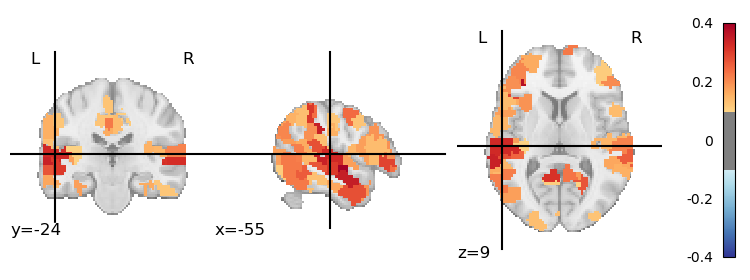

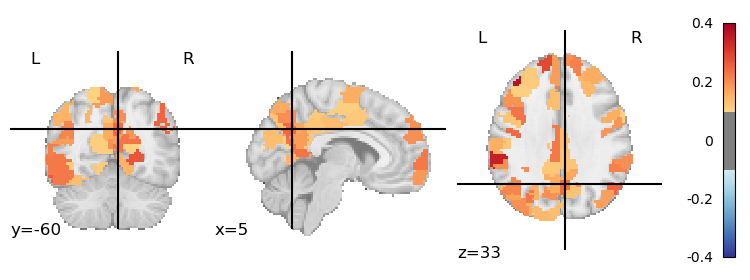

In [60]:
# Invert masker transform to project onto brain
r_img = masker.inverse_transform(r_parcels)

# Plot encoding performance correlations on brain
vmax = .4
threshold = .1
plot_stat_map(r_img, cmap='RdYlBu_r', vmax=vmax, threshold=threshold,
              cut_coords=(-55, -24, 9))

# Plot correlations to visualize posterior medial cortex
plot_stat_map(r_img, cmap='RdYlBu_r', vmax=vmax, threshold=threshold,
              cut_coords=(5, -60, 33));

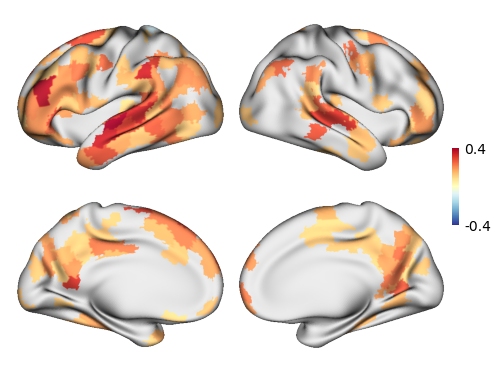

In [61]:
from surfplot.utils import threshold

# Convert volumetric MNI data to fsLR surface
gii_lh, gii_rh = mni152_to_fslr(r_img, method='nearest')

# Threshold at an arbitrary correlation value
gii_lh = threshold(gii_lh.agg_data(), .1)
gii_rh = threshold(gii_rh.agg_data(), .1)

# Plot example ROI on surface
p = Plot(surf_lh=lh, surf_rh=rh, brightness=.7)
p.add_layer({'left': gii_lh, 'right': gii_rh}, cmap='RdYlBu_r', color_range=(-.4, .4))
cbar_kws = dict(location='right', draw_border=False, aspect=10,
                shrink=.2, decimals=1, pad=0, n_ticks=2)
fig = p.build(cbar_kws=cbar_kws)

## References
* Dupré La Tour, T., Eickenberg, M., Nunez-Elizalde, A.O., & Gallant, J. L. (2022).
Feature-space selection with banded ridge regression. *NeuroImage*, *264*, 119728. https://doi.org/10.1016/j.neuroimage.2022.119728

* Dupré La Tour, T., Visconti di Oleggio Castello, M., & Gallant, J. L. (2023). Voxelwise modeling tutorials: an encoding model approach to functional MRI analysis.

* Goldstein, A., Nastase, S. A.\*, Zada, Z.\*, Buchnik, E.\*, Schain, M.\*, Price, A.\*, Aubrey, B.\*, Feder, A.\*, Emanual D.\*, Cohen, A.\*, Jensen, A.\*, Gazula, H., Choe, G., Rao, A., Kim, C., Casto, C., Lora, F., Flinker, A., Devore, S., Doyle, W., Dugan, P., Friedman, D., Hassidim, A., Brenner, M., Matias, Y., Norman, K. A., Devinsky, O., & Hasson, U. (2022). Shared computational principles for language processing in humans and deep language models. *Nature Neuroscience*, *25*, 369–380. https://doi.org/10.1038/s41593-022-01026-4

* Huth, A. G., De Heer, W. A., Griffiths, T. L., Theunissen, F. E., & Gallant, J. L. (2016). Natural speech reveals the semantic maps that tile human cerebral cortex. *Nature*, *532*(7600), 453–458. https://doi.org/10.1038/nature17637

* Mikolov, T., Sutskever, I., Chen, K., Corrado, G. S., & Dean, J. (2013). Distributed representations of words and phrases and their compositionality. In C. J. C. Burges, L. Bottou, M. Welling, Z. Ghahramani, & K. Q. Weinberger (Eds.), *Advances in Neural Information Processing Systems 26* (pp. 3111–3119). Curran Associates. https://papers.nips.cc/paper_files/paper/2013/hash/9aa42b31882ec039965f3c4923ce901b-Abstract.html

* Nastase, S. A., Liu, Y.-F., Hillman, H., Zadbood, A., Hasenfratz, L., Keshavarzian, N., Chen, J., Honey, C. J., Yeshurun, Y., Regev, M., Nguyen, M., Chang, C. H. C., Baldassano, C., Lositsky, O., Simony, E., Chow, M. A., Leong, Y. C., Brooks, P. P., Micciche, E., Choe, G., Goldstein, A., Vanderwal, T., Halchenko, Y. O., Norman, K. A., & Hasson, U. (2021). The "Narratives" fMRI dataset for evaluating models of naturalistic language comprehension. *Scientific Data*, *8*, 250. https://doi.org/10.1038/s41597-021-01033-3

* Radford, A., Wu, J., Child, R., Luan, D., Amodei, D., & Sutskever, I. (2019). Language models are unsupervised multitask learners. *OpenAI Blog*. https://d4mucfpksywv.cloudfront.net/better-language-models/language-models.pdf

* Schaefer, A., Kong, R., Gordon, E. M., Laumann, T. O., Zuo, X. N., Holmes, A. J., Eickhoff, S. B., & Yeo, B. T. (2018). Local-global parcellation of the human cerebral cortex from intrinsic functional connectivity MRI. *Cerebral Cortex*, *28*(9), 3095–3114. https://doi.org/10.1093/cercor/bhx179

* Zada, Z., Goldstein, A. Y., Michelmann, S., Simony, E., Price, A., Hasenfratz, L., Barham, E., Zadbood, A., Doyle, W., Friedman, D., Dugan, P., Melloni, L., Devore, S., Flinker, A., Devinsky, O., Hasson, U.\*, & Nastase, S. A.\* (2023). A shared linguistic space for transmitting our thoughts from brain to brain in natural conversations. *bioRxiv*. https://doi.org/10.1101/2023.06.27.546708